# Downloading the Data from Kaggle

In [1]:
!rm -rf *

In [2]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 6.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=37240ae5b3bfc8b09e59a2ced463c3edabf67078c723356a1dca1a34afd643c0
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akashen","key":"30258b3957b76b8faf0b872fb5d9de80"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [00:41<00:00, 40.8MB/s]
100% 1.69G/1.69G [00:41<00:00, 43.3MB/s]


In [6]:
! mkdir plant-seedlings-classification
! unzip ./plant-seedlings-classification.zip -d plant-seedlings-classification

Streaming output truncated to the last 5000 lines.
  inflating: plant-seedlings-classification/test/adb7a032c.png  
  inflating: plant-seedlings-classification/test/ae90f2827.png  
  inflating: plant-seedlings-classification/test/aecfaed64.png  
  inflating: plant-seedlings-classification/test/aee6fa3df.png  
  inflating: plant-seedlings-classification/test/af45e222a.png  
  inflating: plant-seedlings-classification/test/afa446484.png  
  inflating: plant-seedlings-classification/test/afcf6abd5.png  
  inflating: plant-seedlings-classification/test/b026bf8ca.png  
  inflating: plant-seedlings-classification/test/b03397525.png  
  inflating: plant-seedlings-classification/test/b0acaff4a.png  
  inflating: plant-seedlings-classification/test/b130a0632.png  
  inflating: plant-seedlings-classification/test/b145ba9d4.png  
  inflating: plant-seedlings-classification/test/b1cd2a91e.png  
  inflating: plant-seedlings-classification/test/b215531dd.png  
  inflating: plant-seedlings-classifica

# 1) Data Loading and Preparation

In [7]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
data_dir = './plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [10]:
print("Train Dataset")
train_dataset  = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size= IMG_SIZE,
  batch_size= BATCH_SIZE)

print("Validation Dataset")
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size= IMG_SIZE,
  batch_size=BATCH_SIZE)


Train Dataset
Found 4750 files belonging to 12 classes.
Using 3800 files for training.
Validation Dataset
Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 24
Number of test batches: 6


In [12]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 2) Data Agumentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# 3) Extract bottleneck features 

## Model and Evaluation Templates

In [22]:
def extract_VGG16():
	from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
	return VGG16(weights='imagenet', include_top=False), preprocess_input

def extract_Resnet50():
	from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
	return ResNet50(weights='imagenet', include_top=False), preprocess_input

def extract_InceptionV3():
	from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
	return InceptionV3(weights='imagenet', include_top=False), preprocess_input

In [23]:
def get_model(md):
  base_model, preprocess_input = md()
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(160, 160, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(256)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dense(128)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  outputs = tf.keras.layers.Dense(num_classes)(x)

  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0001

  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

  return model

In [24]:
def train_model(model, filepath):
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)
  
  print("\n Training Started \n")
  history = model.fit(train_ds,
                    epochs=20,
                    validation_data=validation_ds,
                    callbacks=[checkpoint])
  print("\n Training Completed \n")

  return history

In [25]:
def get_plots(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [26]:
def evaluate(filepath):
  print("\n Loading best saved model - ", filepath)

  model = tf.keras.models.load_model(filepath)

  print("\n Getting Confusion matrix and Classification Report on best saved Model \n")
  
  predictions = []
  labels = []
  for image_batch , label_batch in test_ds.as_numpy_iterator():
    predictions = predictions + list(np.argmax(model.predict(image_batch), axis=1))
    labels = labels + list(label_batch)

  print(confusion_matrix(predictions, labels))
  print(classification_report(predictions, labels))

## (a) Extract bottleneck features from VGG16

In [27]:
model = get_model(extract_VGG16)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [28]:
filepath = 'extract_VGG16.hdf5'
history = train_model(model, filepath)


 Training Started 

Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 2.3167 - accuracy: 0.2529
Epoch 00001: val_loss improved from inf to 2.22055, saving model to extract_VGG16.hdf5
119/119 [==============================] - 56s 468ms/step - loss: 2.3167 - accuracy: 0.2529 - val_loss: 2.2205 - val_accuracy: 0.2546
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 1.8448 - accuracy: 0.4089
Epoch 00002: val_loss improved from 2.22055 to 1.87477, saving model to extract_VGG16.hdf5
119/119 [==============================] - 52s 436ms/step - loss: 1.8448 - accuracy: 0.4089 - val_loss: 1.8748 - val_accuracy: 0.3813
Epoch 3/20
119/119 [==============================] - ETA: 0s - loss: 1.6226 - accuracy: 0.4784
Epoch 00003: val_loss improved from 1.87477 to 1.68866, saving model to extract_VGG16.hdf5
119/119 [==============================] - 53s 442ms/step - loss: 1.6226 - accuracy: 0.4784 - val_loss: 1.6887 - val_accuracy: 0.4551
Epoch 4/20
119/119 [

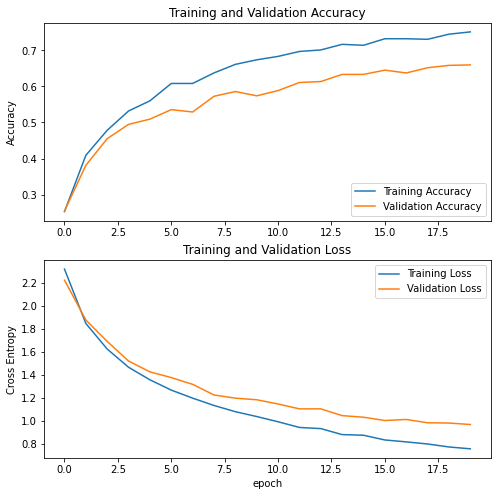

In [29]:
get_plots(history)

In [30]:
evaluate(filepath)


 Loading best saved model -  extract_VGG16.hdf5

 Getting Confusion matrix and Classification Report on best saved Model 

[[ 2  0  0  0  1  0  2  0  0  0  0  0]
 [ 0 13  0  0  0  1  0  0  0  1  0  0]
 [ 0  2  5  1  0  2  0  0  0  2  0  0]
 [ 0  0  2 19  0  1  0  0  0  0  2  0]
 [ 1  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  1]
 [ 5  0  0  0  1  4 21  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  9  0  0  0  1]
 [ 0  1  3  4  0  0  2  0 16  6  2  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0  1  1 16  0]
 [ 0  0  3  1  0  0  0  0  0  0  0 15]]
              precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.76      0.87      0.81        15
           2       0.38      0.42      0.40        12
           3       0.76      0.79      0.78        24
           4       0.50      0.67      0.57         3
           5       0.64      0.94      0.76        17
           6       0.84     

## (b) Extract bottleneck features from Resnet50

In [31]:
model = get_model(extract_Resnet50)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_2 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_______________________________________________________

In [32]:
filepath = 'extract_Resnet50.hdf5'
history = train_model(model, filepath)


 Training Started 

Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 2.1262 - accuracy: 0.2887
Epoch 00001: val_loss improved from inf to 2.05483, saving model to extract_Resnet50.hdf5
119/119 [==============================] - 55s 466ms/step - loss: 2.1262 - accuracy: 0.2887 - val_loss: 2.0548 - val_accuracy: 0.2955
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 1.4780 - accuracy: 0.5571
Epoch 00002: val_loss improved from 2.05483 to 1.63539, saving model to extract_Resnet50.hdf5
119/119 [==============================] - 53s 446ms/step - loss: 1.4780 - accuracy: 0.5571 - val_loss: 1.6354 - val_accuracy: 0.4591
Epoch 3/20
119/119 [==============================] - ETA: 0s - loss: 1.1871 - accuracy: 0.6545
Epoch 00003: val_loss improved from 1.63539 to 1.24619, saving model to extract_Resnet50.hdf5
119/119 [==============================] - 52s 434ms/step - loss: 1.1871 - accuracy: 0.6545 - val_loss: 1.2462 - val_accuracy: 0.6069
Epoch 4/20


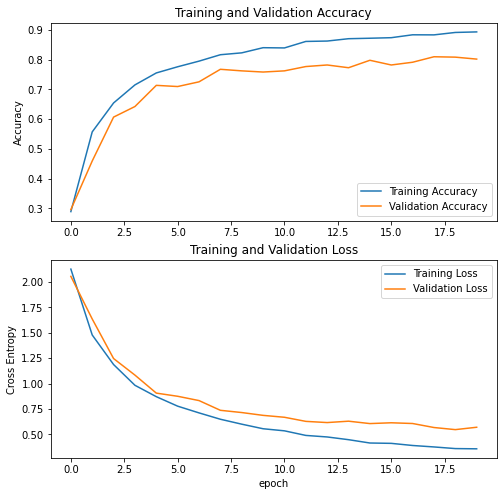

In [33]:
get_plots(history)

In [34]:
evaluate(filepath)


 Loading best saved model -  extract_Resnet50.hdf5

 Getting Confusion matrix and Classification Report on best saved Model 

[[ 6  0  0  0  6  0  6  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0]
 [ 1  1  0  1  1 19  0  0  0  1  0  0]
 [ 1  0  0  0  0  1 24  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  1]
 [ 0  0  0  3  0  0  0  0 14  4  0  1]
 [ 0  0  0  1  0  0  0  0  0  5  1  0]
 [ 0  0  0  1  0  0  0  0  0  0 21  0]
 [ 0  0  1  0  1  3  0  0  1  0  0 20]]
              precision    recall  f1-score   support

           0       0.75      0.33      0.46        18
           1       0.75      1.00      0.86         6
           2       0.93      0.93      0.93        14
           3       0.71      0.94      0.81        16
           4       0.27      1.00      0.43         3
           5       0.79      0.79      0.79        24
           6       0.80  

## (d) Extract bottleneck features from InceptionV3

In [35]:
model = get_model(extract_InceptionV3)
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_______________________________________________________

In [36]:
filepath = 'extract_InceptionV3.hdf5'
history = train_model(model, filepath)


 Training Started 

Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 2.1799 - accuracy: 0.3045
Epoch 00001: val_loss improved from inf to 1.92672, saving model to extract_InceptionV3.hdf5
119/119 [==============================] - 54s 454ms/step - loss: 2.1799 - accuracy: 0.3045 - val_loss: 1.9267 - val_accuracy: 0.3720
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 1.6548 - accuracy: 0.4726
Epoch 00002: val_loss improved from 1.92672 to 1.56741, saving model to extract_InceptionV3.hdf5
119/119 [==============================] - 51s 425ms/step - loss: 1.6548 - accuracy: 0.4726 - val_loss: 1.5674 - val_accuracy: 0.5000
Epoch 3/20
119/119 [==============================] - ETA: 0s - loss: 1.4151 - accuracy: 0.5500
Epoch 00003: val_loss improved from 1.56741 to 1.37958, saving model to extract_InceptionV3.hdf5
119/119 [==============================] - 50s 418ms/step - loss: 1.4151 - accuracy: 0.5500 - val_loss: 1.3796 - val_accuracy: 0.5541
Ep

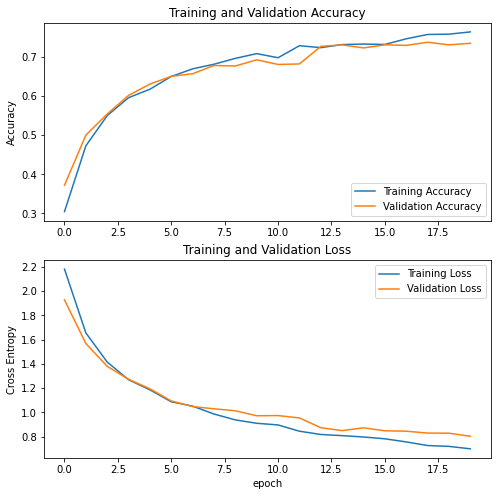

In [37]:
get_plots(history)

In [38]:
evaluate(filepath)


 Loading best saved model -  extract_InceptionV3.hdf5

 Getting Confusion matrix and Classification Report on best saved Model 

[[ 4  0  0  0  2  0  1  0  0  0  0  0]
 [ 0  7  0  0  0  2  0  0  0  2  1  0]
 [ 0  0  8  0  0  1  0  0  0  1  0  0]
 [ 0  1  1 11  1  2  1  0  2  1  0  0]
 [ 1  0  1  0  6  1  0  0  0  0  0  0]
 [ 0  0  0  0  1 16  0  0  0  0  2  0]
 [ 3  0  0  0  2  0 23  0  3  1  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  1]
 [ 0  0  1  1  0  2  1  0 18  1  0  0]
 [ 0  0  0  0  0  1  0  0  1  2  0  0]
 [ 0  0  0  0  0  1  0  0  1  3 18  0]
 [ 0  0  1  0  1  4  1  0  0  0  0 20]]
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.88      0.58      0.70        12
           2       0.67      0.80      0.73        10
           3       0.92      0.55      0.69        20
           4       0.46      0.67      0.55         9
           5       0.53      0.84      0.65        19
           6       0.8

# 4) Save and Load model with highest Accuracy

##  a)	To train the network and save the model with highest validation accuracy

In [39]:
filepath = 'best.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

In [40]:
model1 = get_model(extract_VGG16)
model2 = get_model(extract_Resnet50)
model3 = get_model(extract_InceptionV3)

In [41]:
print("\n Model 1 - VGG16 \n")
model1.fit(train_ds,
                    epochs=10,
                    validation_data=validation_ds,
                    callbacks=[checkpoint])

print("\n Model 2 - Resnet50 \n")
model2.fit(train_ds,
                    epochs=10,
                    validation_data=validation_ds,
                    callbacks=[checkpoint])

print("\n Model 3 - InceptionV3 \n")
model3.fit(train_ds,
                    epochs=10,
                    validation_data=validation_ds,
                    callbacks=[checkpoint])


 Model 1 - VGG16 

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 2.6161 - accuracy: 0.1661
Epoch 00001: val_loss improved from inf to 2.45921, saving model to best.hdf5
119/119 [==============================] - 54s 451ms/step - loss: 2.6161 - accuracy: 0.1661 - val_loss: 2.4592 - val_accuracy: 0.1821
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 1.9514 - accuracy: 0.3524
Epoch 00002: val_loss improved from 2.45921 to 1.96157, saving model to best.hdf5
119/119 [==============================] - 51s 429ms/step - loss: 1.9514 - accuracy: 0.3524 - val_loss: 1.9616 - val_accuracy: 0.3285
Epoch 3/10
119/119 [==============================] - ETA: 0s - loss: 1.6612 - accuracy: 0.4613
Epoch 00003: val_loss improved from 1.96157 to 1.65237, saving model to best.hdf5
119/119 [==============================] - 51s 432ms/step - loss: 1.6612 - accuracy: 0.4613 - val_loss: 1.6524 - val_accuracy: 0.4565
Epoch 4/10
119/119 [============================

## b) Load the model and predict on the test data.

In [42]:
model = tf.keras.models.load_model(filepath)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 402ms/step - loss: 0.6701 - accuracy: 0.0312
Test accuracy : 0.03125
